<a href="https://colab.research.google.com/github/osamja/whats-the-guitar-tab/blob/main/whats_the_tab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pdb

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Estimated tempo: 112.35 beats per minute


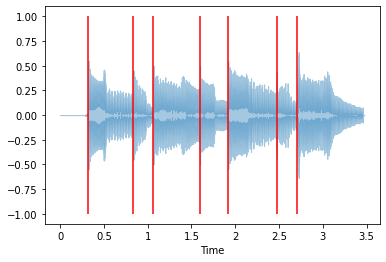

In [ ]:
import librosa

# plot the beat events
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy

# 1. Get the file path to an included audio example

filename = 'drive/MyDrive/whats-the-tab/music/Better-Together-Short_3.mp3'

# waveform y, and sampling rate sr
y, sr = librosa.load(filename)

# 2. Run the default beat tracker 
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 3. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

# plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.4)

# actual timestamp of when each note of Better-Together-Short_3.mp3 was played in seconds
actual_notes = [.318, .828, 1.059, 1.597, 1.912, 2.471, 2.709]
plt.vlines(actual_notes, -1, 1, color='r')
plt.show()

In [ ]:
# https://stackoverflow.com/questions/55283610/how-do-i-get-the-frequencies-from-a-signal

def frequency_spectrum(x, sf):
    """
    Derive frequency spectrum of a signal from time domain
    :param x: signal in the time domain
    :param sf: sampling frequency
    :returns frequencies and their content distribution
    """
    x = x - np.average(x)  # zero-centering

    n = len(x)
    k = np.arange(n)
    tarr = n / float(sf)
    frqarr = k / float(tarr)  # two sides frequency range

    frqarr = frqarr[range(n // 2)]  # one side frequency range

    x = np.fft.fft(x) / n  # fft computing and normalization
    x = x[range(n // 2)]

    return frqarr, abs(x)

In [ ]:
# If f is within tolerance of a note (measured in cents - 1/100th of a semitone)
# return that note, otherwise returns None
# We scale to the 440 octave to check
def get_note_for_freq(f, tolerance=33):
    # Calculate the range for each note
    tolerance_multiplier = 2 ** (tolerance / 1200)
    note_ranges = {
        k: (v / tolerance_multiplier, v * tolerance_multiplier) for (k, v) in NOTES.items()
    }

    # Get the frequence into the 440 octave
    range_min = note_ranges["A"][0]
    range_max = note_ranges["G#"][1]
    if f < range_min:
        while f < range_min:
            f *= 2
    else:
        while f > range_max:
            f /= 2

    # Check if any notes match
    for (note, note_range) in note_ranges.items():
        if f > note_range[0] and f < note_range[1]:
            return note
    return None

In [ ]:
NOTES = {
    "A": 440,
    "A#": 466.1637615180899,
    "B": 493.8833012561241,
    "C": 523.2511306011972,
    "C#": 554.3652619537442,
    "D": 587.3295358348151,
    "D#": 622.2539674441618,
    "E": 659.2551138257398,
    "F": 698.4564628660078,
    "F#": 739.9888454232688,
    "G": 783.9908719634985,
    "G#": 830.6093951598903,
}

In [ ]:
1 # lets extract a small sample window of the signal from our detected note number
# i.e. timestamp_detected_notes = [0.318, 0.828,2.471, 2.709]
# note that each timestamp is an approximated time (manually derived) of when that note was
# played so that's why we grab a small window around this timestamp so that
# we capture the full range of this note.  This is the detected note signal.
def get_note_signal(timestamp_detected_note, y, sr, window_size=500):
  note_signal = int(timestamp_detected_note * sr)
  note_signal_start = (note_signal - window_size)
  note_signal_end = (note_signal + window_size)
  note_signal = y[note_signal_start : note_signal_end]
  
  return note_signal

def predict_notes(timestamp_detected_notes, y, sr, plot_note_frequency_spectrum=False):
  classified_notes = []

  # pdb.set_trace()

  for timestamped_note in timestamp_detected_notes:
    note_signal = get_note_signal(timestamped_note, y, sr)
    freq_array, freq_magnitudes = frequency_spectrum(note_signal, sr)

    if plot_note_frequency_spectrum:
      plt.plot(freq_array,abs(freq_magnitudes)) # plotting the spectrum
      plt.xlabel('Freq (Hz)')
      plt.ylabel('|Y(freq)|')
      plt.show()

    # find the frequency peaks
    peak_indicies, props = scipy.signal.find_peaks(freq_magnitudes, height=0.015)
    # print("peak_indicies: ", peak_indicies)
    # print("Peaks of more than 1.5 percent of total frequency contribution:")
    highest_magnitude, highest_magnitude_index, highest_magnitude_freq = 0, 0, 0
    for j, peak in enumerate(peak_indicies):
        freq = freq_array[peak]
        magnitude = props["peak_heights"][j]
        if (magnitude > highest_magnitude and (get_note_for_freq(freq) != None)):
          highest_magnitude = magnitude
          highest_magnitude_index = j
          highest_magnitude_freq = freq
        # print("{:.1f} hz with magnitude {:.3f}".format(freq, magnitude))
    # print("highest_magnitude, highest_magnitude_index, highest_magnitude_freq: ", highest_magnitude, highest_magnitude_index, highest_magnitude_freq)
    detected_note = get_note_for_freq(highest_magnitude_freq)
    if detected_note == None:
      detected_note = 'U'
    classified_notes += detected_note
    # print("detected_note: ", detected_note)

  return classified_notes

# hmm Im realizing that because of the slides, the signal window should probably be sliding as well...
# in current state either start or end is an acceptable note
correct_tabs = ['10/12 D', '12G', '12/10 D', '10G', '10/7D', '7G', '7/5 D']
correct_notes = ['C/D', 'G', 'D/C', 'F', ' C/A', 'D', 'A/G']

classified_notes = predict_notes(actual_notes, y, sr)
get_note_for_freq(264.6)
print("classified_notes: ", (classified_notes))
print("correct_notes", correct_notes)

classified_notes:  ['C', 'G', 'G', 'C', 'C', 'A', 'A']
correct_notes ['C/D', 'G', 'D/C', 'F', ' C/A', 'D', 'A/G']


Note Detection:
 - Detect when a note was played

predicted_volume_indices:  [187, 213, 269, 294, 309, 321, 379, 478, 605, 723, 754, 926, 986]
wav_locations:  [9350, 10650, 13450, 14700, 15450, 16050, 18950, 23900, 30250, 36150, 37700, 46300, 49300]
predicted_times:  [0.42403628117913833, 0.48299319727891155, 0.6099773242630385, 0.6666666666666666, 0.7006802721088435, 0.7278911564625851, 0.8594104308390023, 1.0839002267573696, 1.3718820861678005, 1.6394557823129252, 1.709750566893424, 2.0997732426303855, 2.235827664399093]
actual times:  [0.318, 0.828, 1.059, 1.597, 1.912, 2.471, 2.709]


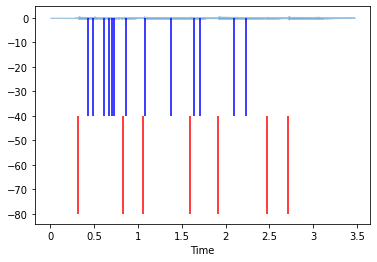

7011.900000000001
1533


array([-53.104664 , -56.586838 , -63.27642  , -24.97081  , -14.087768 ,
        -6.9750614], dtype=float32)

In [ ]:
from scipy.signal import butter


# Very simple implementation, just requires a minimum volume and looks for left edges by
# comparing with the prior sample, also requires a minimum distance between starts
# Future improvements could include smoothing and/or comparing multiple samples
#
# song: pydub.AudioSegment
# plot: bool, whether to show a plot of start times
# actual_starts: []float, time into song of each actual note start (seconds)
#
# Returns perdicted starts in ms
def predict_note_starts(song, plot, actual_starts):
    # Size of segments to break song into for volume calculations
    SEGMENT_MS = 50
    # Minimum volume necessary to be considered a note
    VOLUME_THRESHOLD = -20
    # The increase from one sample to the next required to be considered a note
    EDGE_THRESHOLD = 27
    # Throw out any additional notes found in this window
    MIN_MS_BETWEEN = 200

    # Filter out lower frequencies to reduce noise
    # song = song.high_pass_filter(80, order=4)
    # dBFS is decibels relative to the maximum possible loudness
    volume = librosa.amplitude_to_db(y[::SEGMENT_MS])
    
    predicted_starts = []
    predicted_volume_indices = []
    for i in range(1, len(volume)):
        if i == 361:
          # pdb.set_trace()
          sammy = 'hi'
        if volume[i] > VOLUME_THRESHOLD and volume[i] - volume[i - 1] > EDGE_THRESHOLD:
            ms = i * SEGMENT_MS
            # Ignore any too close together
            if len(predicted_starts) == 0 or ms - predicted_starts[-1] >= MIN_MS_BETWEEN:
                predicted_volume_indices.append(i)
                predicted_starts.append(ms)

    # If actual note start times are provided print a comparison
    # if len(actual_starts) > 0:
    #     print("Approximate actual note start times ({})".format(len(actual_starts)))
    #     print(" ".join(["{:5.2f}".format(s) for s in actual_starts]))
    #     print("Predicted note start times ({})".format(len(predicted_starts)))
    #     print(" ".join(["{:5.2f}".format(ms / 1000) for ms in predicted_starts]))

    # Plot the volume over time (sec)
    if plot:
        x_axis = np.arange(len(volume)) * (SEGMENT_MS / 1000)
        plt.plot(x_axis, volume)

        # Add vertical lines for predicted note starts and actual note starts
        for s in actual_starts:
            plt.axvline(x=s, color="r", linewidth=0.5, linestyle="-")
        for ms in predicted_starts:
            plt.axvline(x=(ms / 1000), color="g", linewidth=0.5, linestyle=":")

        plt.show()

    return predicted_starts, predicted_volume_indices

predicted_notes , predicted_volume_indices = predict_note_starts(y, False, actual_notes)

wav_locations = []
predicted_times = []
for volume_index in predicted_volume_indices:
  wav_loc_index = volume_index * 50
  wav_locations.append(wav_loc_index)
  predicted_times.append(((wav_loc_index / sr)))


print("predicted_volume_indices: ", predicted_volume_indices)
print("wav_locations: ", wav_locations)
print("predicted_times: ", predicted_times)
print("actual times: ", actual_notes)

librosa.display.waveshow(y, sr=sr, alpha=0.4)
volume = librosa.amplitude_to_db(y[::50])
# librosa.display.waveshow(volume)
plt.vlines(actual_notes, -80, -40, color='r')
plt.vlines(predicted_times, -40, 0, color='b')
plt.show()


first_note = actual_notes[0] * sr
print(first_note) # 7011
print(len(volume))
volume[137:143]

In [ ]:
c
# debug why first timestamp at 0.32 secones was not included in prediction

def debug_first_timestamp(step_size=50):
  first_note_timestamp = actual_notes[0]
  first_note_timestamp

  wav_loc_index = int(first_note_timestamp * sr) 
  wav_loc_index
  volume_index = int(wav_loc_index / step_size)
  print(volume_index) 
  first_note = actual_notes[0] * sr
  print(volume[137:143])
  print("estimate of first actual note: ", volume[140])


debug_first_timestamp()

140
[-53.104664  -56.586838  -63.27642   -24.97081   -14.087768   -6.9750614]
estimate of first actual note:  -24.97081


In [ ]:
# debug why first timestamp at 0.32 secones was not included in prediction

# timestamp in seconds, result is info about volume around that timestamp
def debug_timestamp(timestamp, step_size=50):
  wav_loc_index = int(timestamp * sr)
  volume_index = int(wav_loc_index / step_size)
  print("volume_index: ", volume_index)
  print(volume[volume_index])
  print(volume[volume_index - 2 : volume_index + 2])


debug_timestamp(0.82)

volume_index:  361
-18.49541
[-38.3985   -18.746155 -18.49541  -34.28282 ]


Resources and Credit

- https://github.com/akshaybahadur21/Guitar-Learner
- Von Seggern note recognition medium: https://github.com/ianvonseggern1/note-prediction/blob/master/note_recognition.py
- https://stackoverflow.com/questions/55283610/how-do-i-get-the-frequencies-from-a-signal
- https://i.pinimg.com/736x/e7/66/fe/e766fe6b05367c663a131809c5d5582d.jpg


Learnings
- I realized I'm essentially trying to build a signal processor.  and i don't know much about signal processing so this project was quite fun.

In [ ]:
.32*22050

7056.0

# Let's use Machine Learning instead

Man, I'm positive that the code above is super buggy and would need a lot of effort to be anything close to what I want.  I'm too lazy to code this myself, so let's see if we can get an AI to do this job.  

### 


